# 1. Business Understanding
This project analyzes Airbnb data from Boston and focuses on three key business questions:


* What are the seasonal patterns in pricing and availability across different neighborhoods and property types?

* Which property characteristics and host behaviors have the strongest relationship with guest satisfaction scores?
   
* What are the key factors that influence listing prices in different neighborhoods, and how do amenities and property? 

Below are the business areas that our analysis dives in:
    
### Seasonal Trends Analysis

* Examines how prices vary across months and neighborhoods
* Tracks availability patterns throughout the year
* Studies seasonal pricing strategies
* Uses calendar data to identify peak and off-peak periods


### Property Market Analysis

* Analyzes price variations by property type and location
* Studies relationship between amenities and pricing
* Investigates how property features (bedrooms, bathrooms, etc.) influence price
* Uses Random Forest to identify key price-influencing factors


### Property Performance Analysis

* Examines relationship between property characteristics and review scores
* Analyzes correlation between price points and ratings
* Identifies features that contribute to higher guest satisfaction
* Studies impact of location on property performance


### The analysis uses three datasets:

* Listings data: Contains property features, host information, and pricing
* Calendar data: Daily availability and pricing information
* Reviews data: Guest ratings and review scores

Key visualizations include seasonal price trends, feature importance plots, and correlation analyses to help understand the Airbnb market dynamics.

In [13]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import calendar
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Set styling for plots
plt.style.use('seaborn')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)

# 2. Data Understanding

In [117]:
#Boston dataset
 
listings_df = pd.read_csv("listings.csv")
calendar_df = pd.read_csv("calendar.csv")
reviews_df = pd.read_csv("reviews.csv")
def load_data():
    """Load and clean the Airbnb datasets.
    
    Loads three CSV files: listings.csv, calendar.csv, and reviews.csv.
    Performs initial data cleaning including price formatting, date conversion,
    and boolean value standardization.
    
    Returns:
        tuple: Three pandas DataFrames:
            - listings_df: Contains property listings information
            - calendar_df: Contains availability and pricing by date
            - reviews_df: Contains user reviews and ratings
    
    Data Cleaning Steps:
        1. Price columns: Removes '$' and ',' characters, converts to float
        2. Date columns: Converts to datetime format
        3. Boolean columns: Standardizes 't'/'f' to True/False"""
   
    
    # Basic price cleaning
    for df in [listings_df, calendar_df]:
        if "price" in df.columns:
            df["price"] = df["price"].astype(str)
            df["price"] = df["price"].apply(lambda x: x.replace("$", "").replace(",", ""))
            df["price"] = pd.to_numeric(df["price"], errors="coerce")
    
    # Convert boolean column
    if "available" in calendar_df.columns:
        calendar_df["available"] = calendar_df["available"].map({"t": True, "f": False})
    
    # Convert dates
    calendar_df["date"] = pd.to_datetime(calendar_df["date"], errors="coerce")
    reviews_df["date"] = pd.to_datetime(reviews_df["date"], errors="coerce")
    
    return listings_df, calendar_df, reviews_df

In [96]:
listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,250.0,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United State

In [125]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [97]:
calendar_df

,listing_id,date,available,price
0,12147973,2017-09-05,False,NaN
1,12147973,2017-09-04,False,NaN
2,12147973,2017-09-03,False,NaN
3,12147973,2017-09-02,False,NaN
4,12147973,2017-09-01,False,NaN
...,...,...,...,...
1308885,14504422,2016-09-10,False,NaN
1308886,14504422,2016-09-09,False,NaN
1308887,14504422,2016-09-08,False,NaN
1308888,14504422,2016-09-07,False,NaN


In [124]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308890 non-null  int64         
 1   date        1308890 non-null  datetime64[ns]
 2   available   1308890 non-null  bool          
 3   price       643037 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 31.2 MB


In [98]:
reviews_df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...
...,...,...,...,...,...,...
68270,7462268,80537457,2016-06-18,22034145,Antonio,Joe y su mujer son encantadores. La habitación...
68271,7462268,83640094,2016-07-03,40052513,Steve,Joe was on his way to Jamaica to be married! o...
68272,7462268,85797088,2016-07-13,77129134,Nick,The room was very clean as were the bathrooms ...
68273,7462268,97264637,2016-08-26,15799803,Vid,Staying in Lower Allston at Joe and Nancy's pl...


In [123]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     68275 non-null  int64         
 1   id             68275 non-null  int64         
 2   date           68275 non-null  datetime64[ns]
 3   reviewer_id    68275 non-null  int64         
 4   reviewer_name  68275 non-null  object        
 5   comments       68222 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.1+ MB


In [101]:
#Initial Data Exploration
print("=== DATASET SHAPES ===")
print(f"Listings DataFrame: {listings_df.shape}")
print(f"Calendar DataFrame: {calendar_df.shape}")
print(f"Reviews DataFrame: {reviews_df.shape}")


=== DATASET SHAPES ===
Listings DataFrame: (3585, 95)
Calendar DataFrame: (1308890, 4)
Reviews DataFrame: (68275, 6)


In [103]:
# Add time-based features
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['day_of_week'] = calendar_df['date'].dt.day_name()
calendar_df['season'] = pd.cut(calendar_df['date'].dt.month, 
                             bins=[0,3,6,9,12], 
                             labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Basic statistics
print("\nDate range:", calendar_df['date'].min(), "to", calendar_df['date'].max())
print("\nPrice range: ${:.2f} to ${:.2f}".format(
    calendar_df['price'].min(), 
    calendar_df['price'].max()
))


Date range: 2016-09-06 00:00:00 to 2017-09-05 00:00:00

Price range: $11.00 to $7163.00


# 3. Data Preparation

In [121]:
def prepare_seasonal_analysis(calendar_df, listings_df):
    """   Prepare data for seasonal trend analysis.
    
    Adds temporal features and merges calendar data with property information.
    
    Args:
        calendar_df (pd.DataFrame): Calendar data with dates and availability
        listings_df (pd.DataFrame): Property listings data
    
    Returns:
        pd.DataFrame: Enhanced dataset with seasonal features including:
            - month: Numeric month (1-12)
            - season: Categorical season (Winter, Spring, Summer, Fall)
            - Property information merged from listings
    
    Features Created:
        - Month extraction from dates
        - Season mapping
        - Property type and neighborhood information"""
    
    seasonal_df = calendar_df.copy()
    seasonal_df["month"] = seasonal_df["date"].dt.month
    seasonal_df["season"] = seasonal_df["date"].dt.month.map({
        1: "Winter", 2: "Winter", 3: "Spring",
        4: "Spring", 5: "Spring", 6: "Summer",
        7: "Summer", 8: "Summer", 9: "Fall",
        10: "Fall", 11: "Fall", 12: "Winter"
    })
    
    # Merge with listings
    listings_features = ["id", "neighbourhood_cleansed", "property_type"]
    seasonal_df = seasonal_df.merge(
        listings_df[listings_features],
        left_on="listing_id",
        right_on="id"
    )
    
    return seasonal_df



In [120]:
def prepare_satisfaction_analysis(listings_df, reviews_df):
    """Prepare data for guest satisfaction analysis.
    
    Calculates review statistics per listing and merges with property data.
    
    Args:
        listings_df (pd.DataFrame): Property listings data
        reviews_df (pd.DataFrame): Review data
    
    Returns:
        pd.DataFrame: Enhanced dataset with review metrics including:
            - review_count: Number of reviews per property
            - review_timespan: Days between first and last review
            - reviews_per_month: Review frequency
    
    Calculations:
        - Aggregates review counts
        - Calculates review timespan
        - Computes review frequency"""
    
    review_stats = reviews_df.groupby("listing_id").agg({
        "id": "count",
        "date": lambda x: (x.max() - x.min()).days
    }).reset_index()
    
    review_stats.columns = ["listing_id", "review_count", "review_timespan"]
    satisfaction_df = listings_df.merge(review_stats, left_on="id", right_on="listing_id")
    satisfaction_df["reviews_per_month"] = (
        satisfaction_df["review_count"] / 
        (satisfaction_df["review_timespan"] / 30)
    ).fillna(0)
    
    return satisfaction_df



In [119]:
def prepare_pricing_analysis(listings_df):
    """    Prepare data for market pricing analysis.
    
    Creates features from property characteristics and amenities.
    
    Args:
        listings_df (pd.DataFrame): Property listings data
    
    Returns:
        pd.DataFrame: Enhanced dataset with additional features:
            - amenities_count: Number of amenities
            - text_length features for description fields
    
    Feature Engineering:
        - Counts amenities
        - Creates text length metrics
        - Handles missing valuess"""
    pricing_df = listings_df.copy()
    
    if "amenities" in pricing_df.columns:
        pricing_df["amenities_count"] = pricing_df["amenities"].str.count(",").fillna(0) + 1
    
    text_cols = ["name", "summary", "space", "description"]
    for col in text_cols:
        if col in pricing_df.columns:
            pricing_df[f"{col}_length"] = pricing_df[col].str.len().fillna(0)
    
    return pricing_df



In [80]:
def analyze_seasonal_trends(seasonal_df):
    """  Analyze seasonal patterns in pricing and availability.
    
    Creates visualizations and statistics for temporal patterns.
    
    Args:
        seasonal_df (pd.DataFrame): Prepared seasonal data
    
    Returns:
        pd.DataFrame: Monthly statistics including:
            - Average price by month and neighborhood
            - Price standard deviation
            - Availability rates
    
    Visualizations:
        1. Price trends over months by neighborhood
        2. Availability rates over time
        3. Seasonal price distributions
        4. Property type availability heatmap"""
    # Monthly statistics
    monthly_stats = seasonal_df.groupby(["month", "neighbourhood_cleansed"]).agg({
        "price": ["mean", "std"],
        "available": lambda x: x.mean() * 100
    }).reset_index()
    
    monthly_stats.columns = ["month", "neighbourhood", "price_mean", "price_std", "availability_rate"]
    
    # Plot 1: Price Trends
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    sns.lineplot(
        data=monthly_stats,
        x="month",
        y="price_mean",
        hue="neighbourhood"
    )
    plt.title("Average Price by Month and Neighborhood")
    plt.xlabel("Month")
    plt.ylabel("Average Price ($)")
    plt.xticks(range(1, 13), calendar.month_abbr[1:])
    
    # Plot 2: Availability Trends
    plt.subplot(2, 1, 2)
    sns.lineplot(
        data=monthly_stats,
        x="month",
        y="availability_rate",
        hue="neighbourhood"
    )
    plt.title("Availability Rate by Month and Neighborhood")
    plt.xlabel("Month")
    plt.ylabel("Availability Rate (%)")
    plt.xticks(range(1, 13), calendar.month_abbr[1:])
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Price Distribution by Season
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=seasonal_df,
        x="season",
        y="price",
        order=["Winter", "Spring", "Summer", "Fall"]
    )
    plt.title("Price Distribution by Season")
    plt.xticks(rotation=0)
    plt.ylabel("Price ($)")
    plt.show()
    
    # Plot 4: Property Type Availability by Season
    seasonal_df["season_month"] = seasonal_df["date"].dt.strftime("%B")
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        seasonal_df.pivot_table(
            index="property_type",
            columns="season_month",
            values="available",
            aggfunc="mean"
        ).fillna(0) * 100,
        cmap="YlOrRd",
        annot=True,
        fmt=".1f"
    )
    plt.title("Property Type Availability by Month (%)")
    plt.tight_layout()
    plt.show()
    
    return monthly_stats





# 4. Data Modeling

In [81]:
def analyze_satisfaction_drivers(satisfaction_df):
    """AAnalyze factors influencing guest satisfaction.
    
    Performs correlation analysis and builds predictive model.
    
    Args:
        satisfaction_df (pd.DataFrame): Prepared satisfaction data
    
    Returns:
        pd.DataFrame: Feature importance results with columns:
            - feature: Name of the property characteristic
            - importance: Relative importance score
    
    Analysis Components:
        1. Correlation analysis with review scores
        2. Random Forest model for feature importance
        3. Visualization of relationships"""
    
    # Feature correlations
    features = ["accommodates", "bathrooms", "bedrooms", "beds", "price", 
                "reviews_per_month", "review_scores_rating"]
    
    # Plot 1: Correlation Matrix
    plt.figure(figsize=(12, 10))
    correlation_df = satisfaction_df[features].corr()
    sns.heatmap(correlation_df, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation Matrix of Key Features")
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Price vs Rating Scatter
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        data=satisfaction_df,
        x="price",
        y="review_scores_rating",
        alpha=0.5
    )
    plt.title("Price vs Review Scores")
    
    # Plot 3: Reviews per Month vs Rating
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        data=satisfaction_df,
        x="reviews_per_month",
        y="review_scores_rating",
        alpha=0.5
    )
    plt.title("Review Frequency vs Scores")
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Rating Distribution by Property Type
    plt.figure(figsize=(15, 6))
    sns.boxplot(
        data=satisfaction_df,
        x="property_type",
        y="review_scores_rating"
    )
    plt.title("Review Scores by Property Type")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot 5: Rating Components Comparison
    rating_components = ["review_scores_accuracy", "review_scores_cleanliness",
                        "review_scores_checkin", "review_scores_communication",
                        "review_scores_location", "review_scores_value"]
    
    plt.figure(figsize=(12, 6))
    satisfaction_df[rating_components].mean().plot(kind='bar')
    plt.title("Average Scores Across Rating Components")
    plt.ylabel("Average Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Feature Importance Analysis
    X = satisfaction_df[["accommodates", "bathrooms", "bedrooms", "beds", "price"]].fillna(0)
    y = satisfaction_df["review_scores_rating"].fillna(0)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)
    
    # Plot 6: Feature Importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="importance", y="feature")
    plt.title("Feature Importance for Review Scores")
    plt.tight_layout()
    plt.show()
    
    return importance_df


In [111]:
def analyze_market_pricing(pricing_df):
    """  Analyze factors influencing listing prices.
    
    Builds predictive model for price and analyzes feature importance.
    
    Args:
        pricing_df (pd.DataFrame): Prepared pricing data
    
    Returns:
        pd.DataFrame: Feature importance results showing impact on price
    
    Model Components:
        1. Numeric feature standardization
        2. Categorical feature encoding
        3. Random Forest regression
        4. Feature importance calculation
    
    Preprocessing:
        - Handles missing values
        - Scales numeric features
        - One-hot encodes categorical variables"""
    
    # Plot 1: Price Distribution
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(pricing_df["price"].clip(0, pricing_df["price"].quantile(0.95)), bins=50)
    plt.title("Price Distribution (95th percentile)")
    plt.xlabel("Price ($)")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=pricing_df, y="price")
    plt.title("Price Box Plot")
    plt.ylabel("Price ($)")
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Price by Neighborhood and Room Type
    plt.figure(figsize=(15, 6))
    sns.boxplot(
        data=pricing_df,
        x="neighbourhood_cleansed",
        y="price",
        hue="room_type"
    )
    plt.title("Price Distribution by Neighborhood and Room Type")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Price vs Size Metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    size_metrics = ["accommodates", "bedrooms", "beds", "bathrooms"]
    
    for ax, metric in zip(axes.ravel(), size_metrics):
        sns.scatterplot(
            data=pricing_df,
            x=metric,
            y="price",
            alpha=0.5,
            ax=ax
        )
        ax.set_title(f"Price vs {metric.capitalize()}")
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Amenities Impact
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=pricing_df,
        x="amenities_count",
        y="price",
        alpha=0.5
    )
    plt.title("Price vs Number of Amenities")
    plt.tight_layout()
    plt.show()
    
    # Modeling and Feature Importance
    numeric_features = ["accommodates", "bathrooms", "bedrooms", "beds", "amenities_count"]
    categorical_features = ["neighbourhood_cleansed", "property_type", "room_type"]
    
    X = pricing_df[numeric_features + categorical_features].copy()
    y = pricing_df["price"]
    
    X[numeric_features] = X[numeric_features].fillna(0)
    X[categorical_features] = X[categorical_features].fillna("Unknown")
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(drop="first", sparse=False), categorical_features)
        ]
    )
    
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    
    # Get feature names after preprocessing
    feature_names = (numeric_features + 
                    [f"{feature}_{val}" for feature, vals in 
                     zip(categorical_features,
                         model.named_steps["preprocessor"]
                         .named_transformers_["cat"]
                         .categories_)
                     for val in vals[1:]])
    
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": model.named_steps["regressor"].feature_importances_
    }).sort_values("importance", ascending=False)
    
    # Plot 5: Feature Importance
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=importance_df.head(15),
        x="importance",
        y="feature"
    )
    plt.title("Top 15 Features Influencing Price")
    plt.tight_layout()
    plt.show()
    
    return importance_df


        


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 130)

Loading and preparing data...

Analyzing seasonal trends...


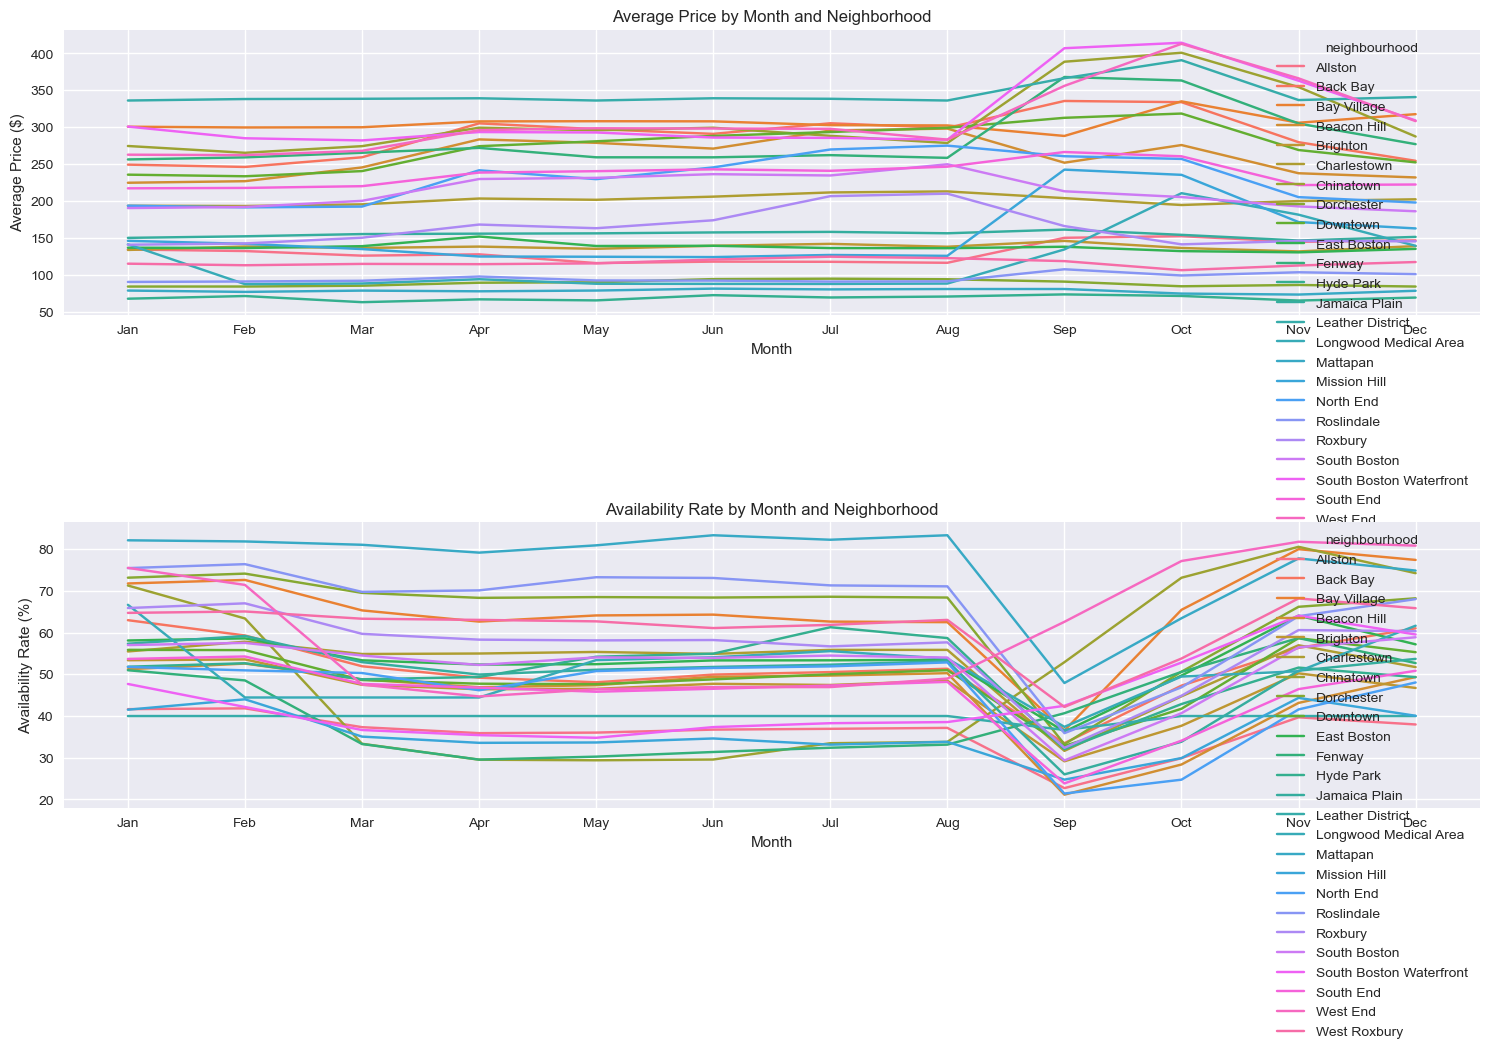

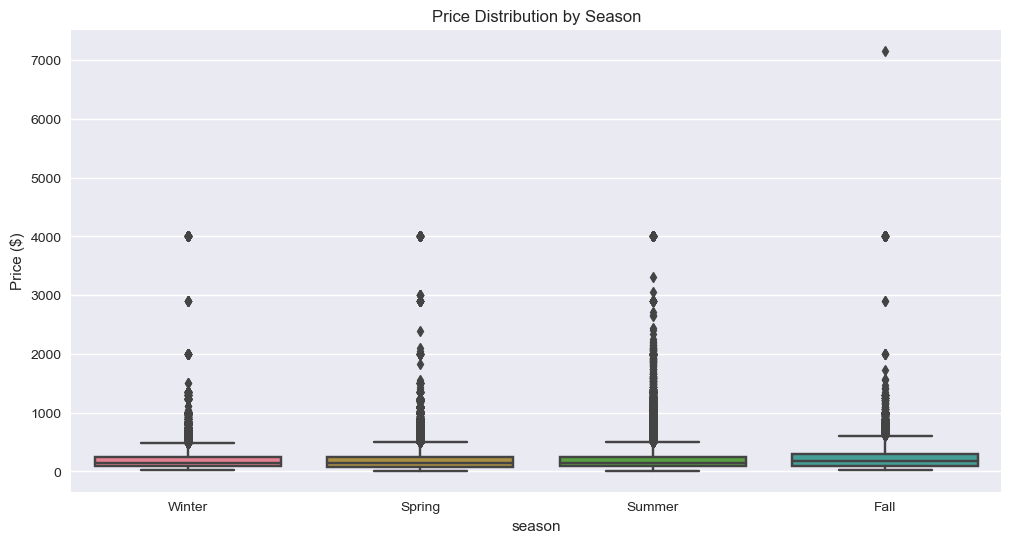

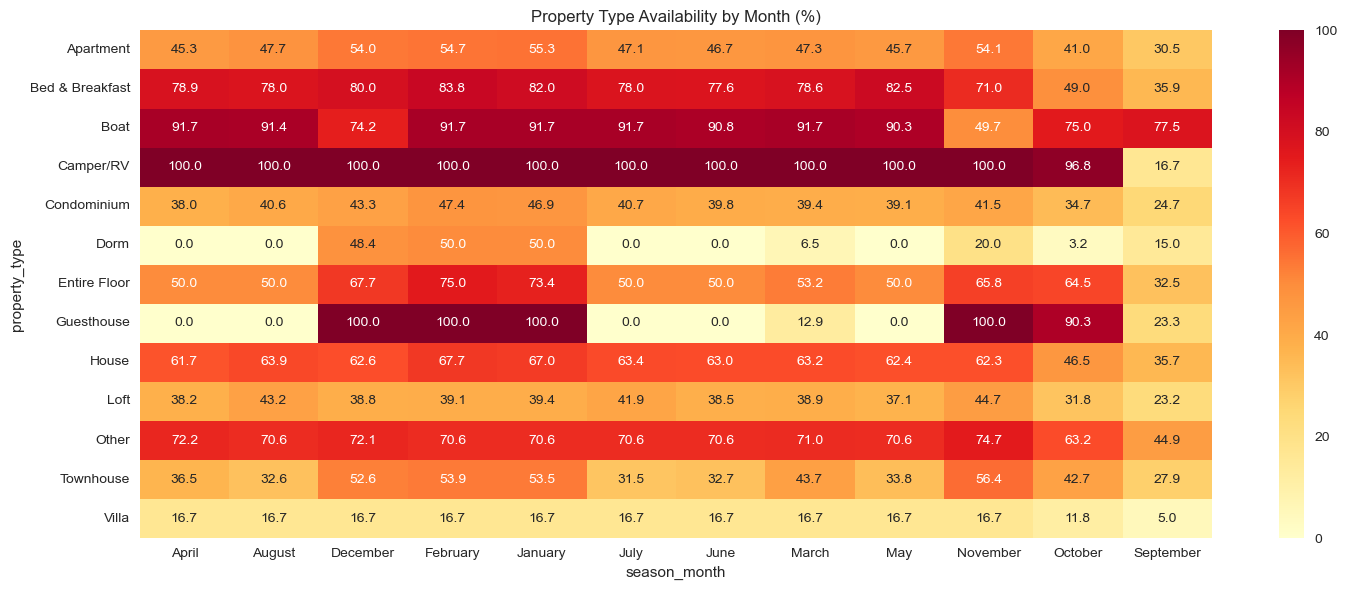


Analyzing satisfaction drivers...


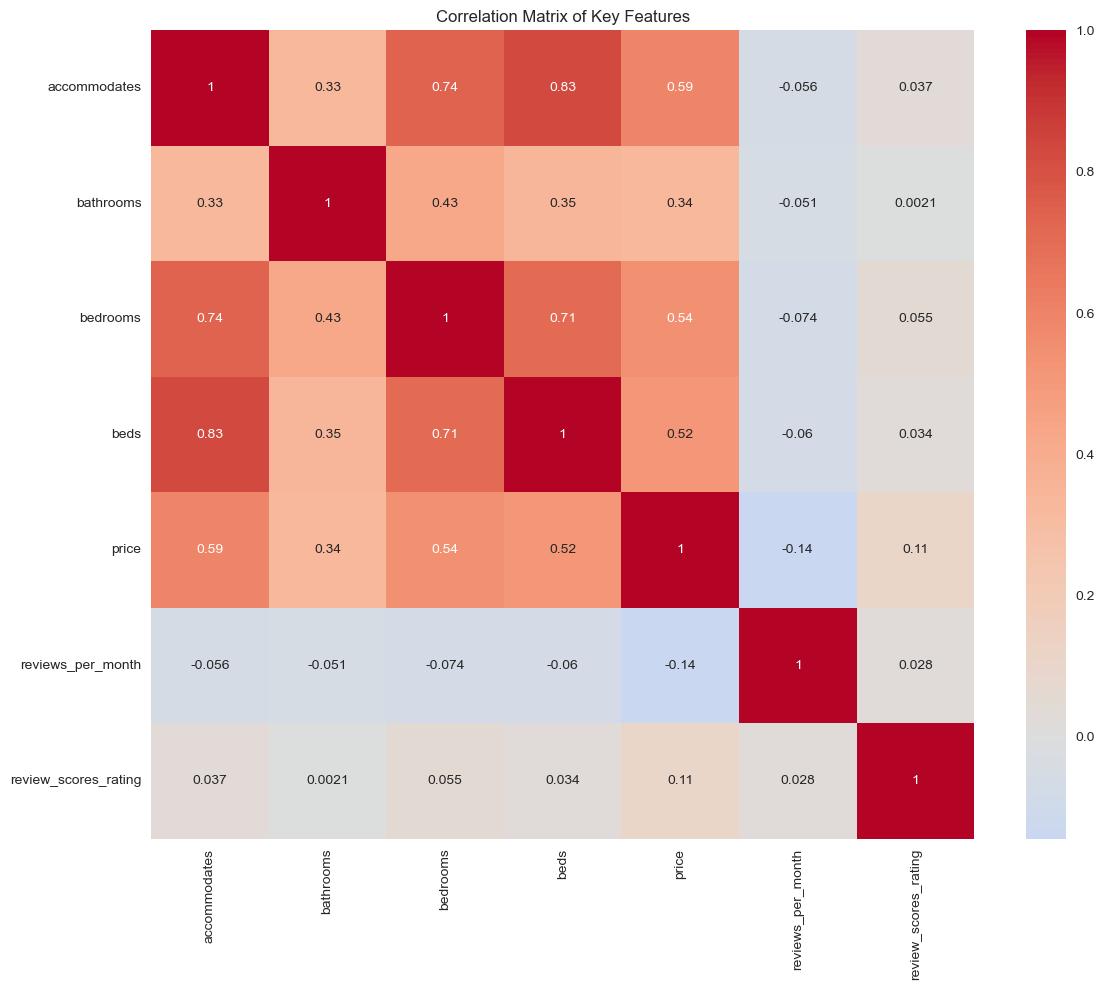

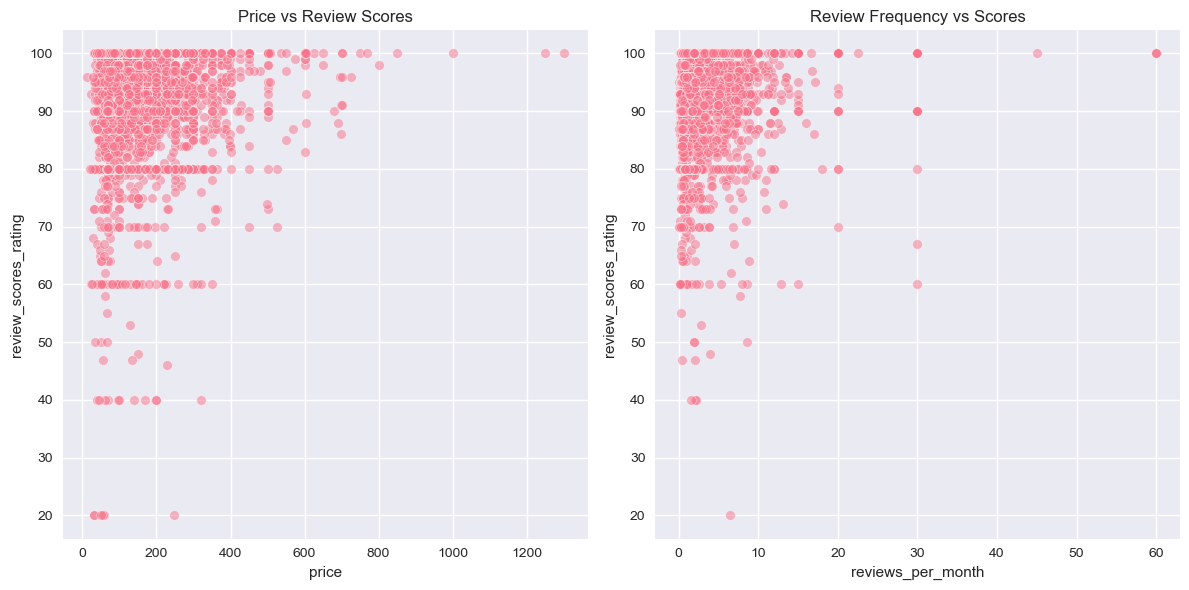

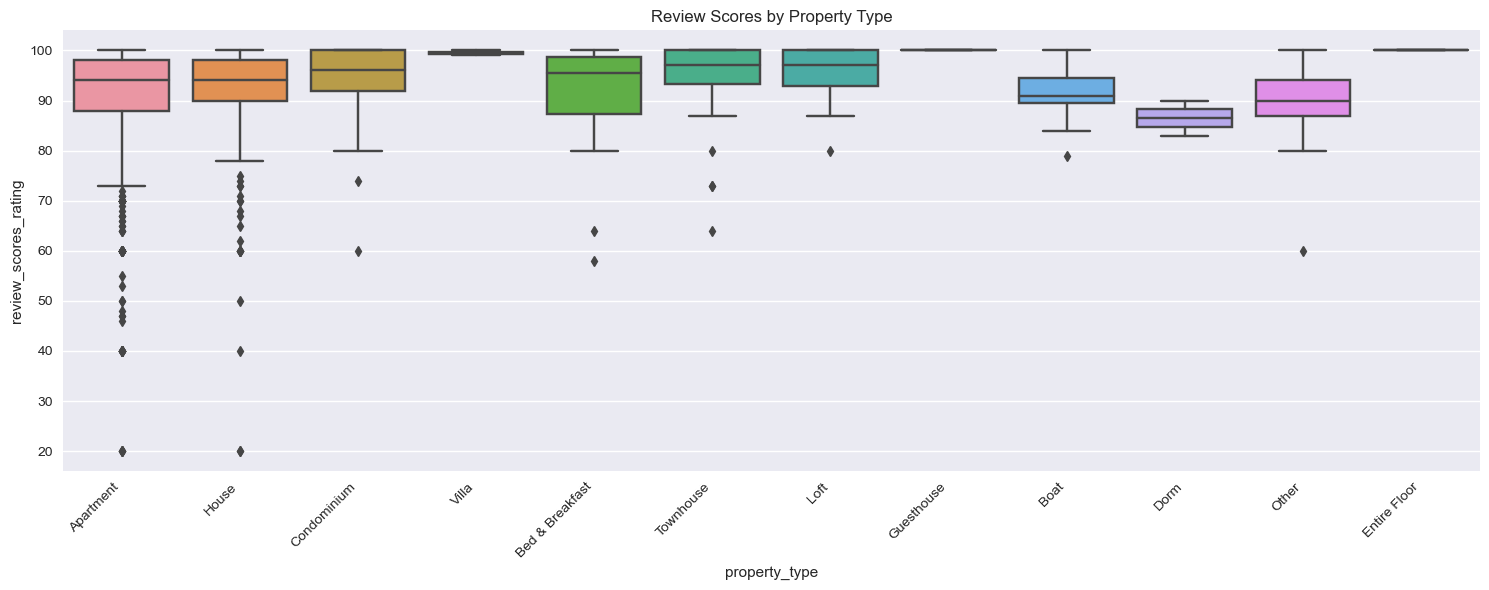

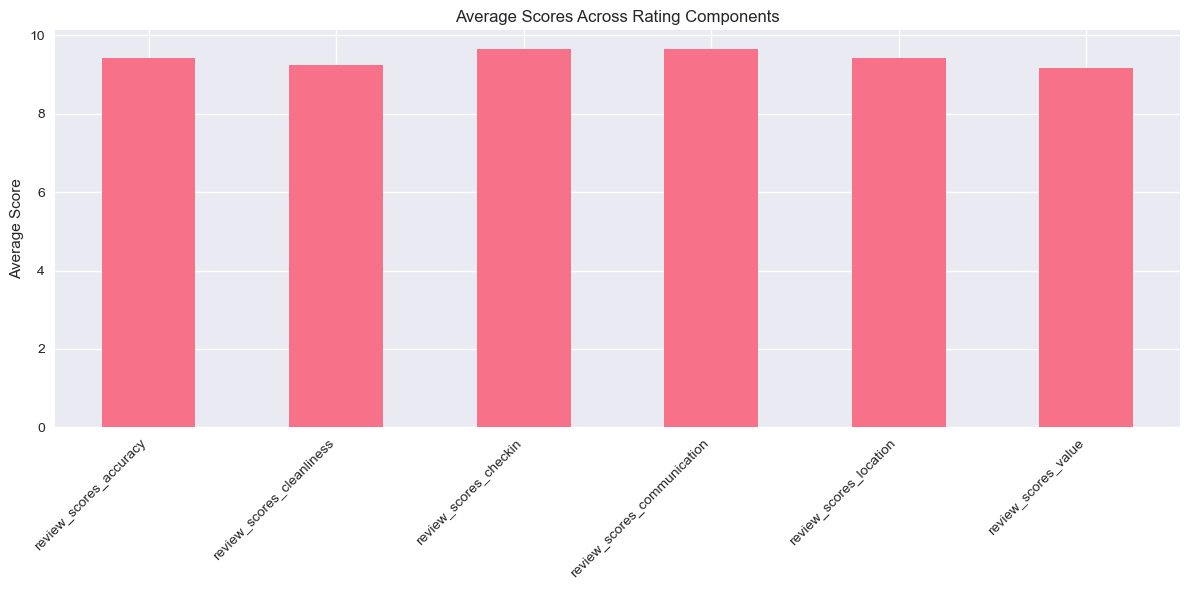

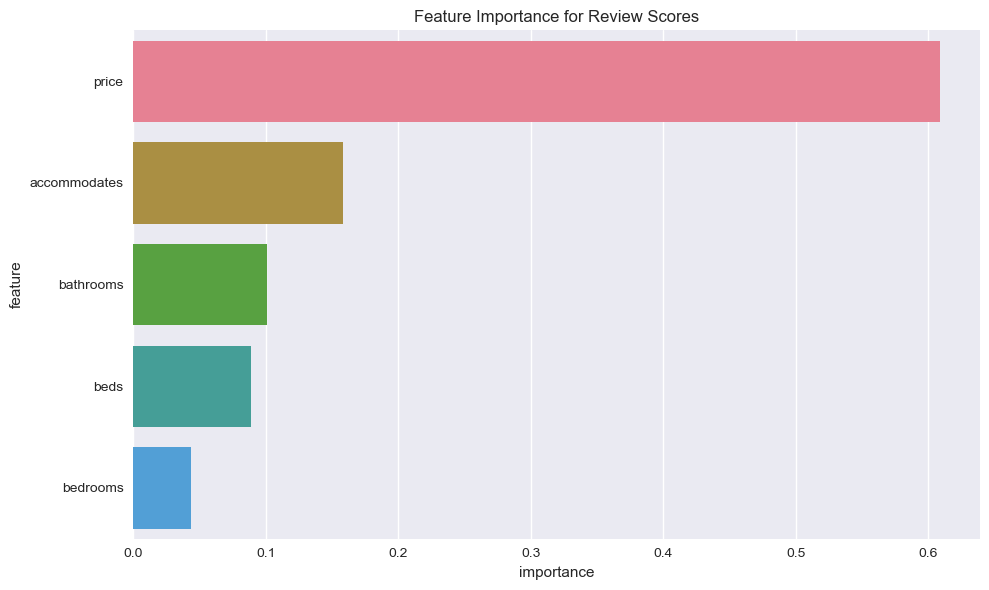


Analyzing market pricing factors...


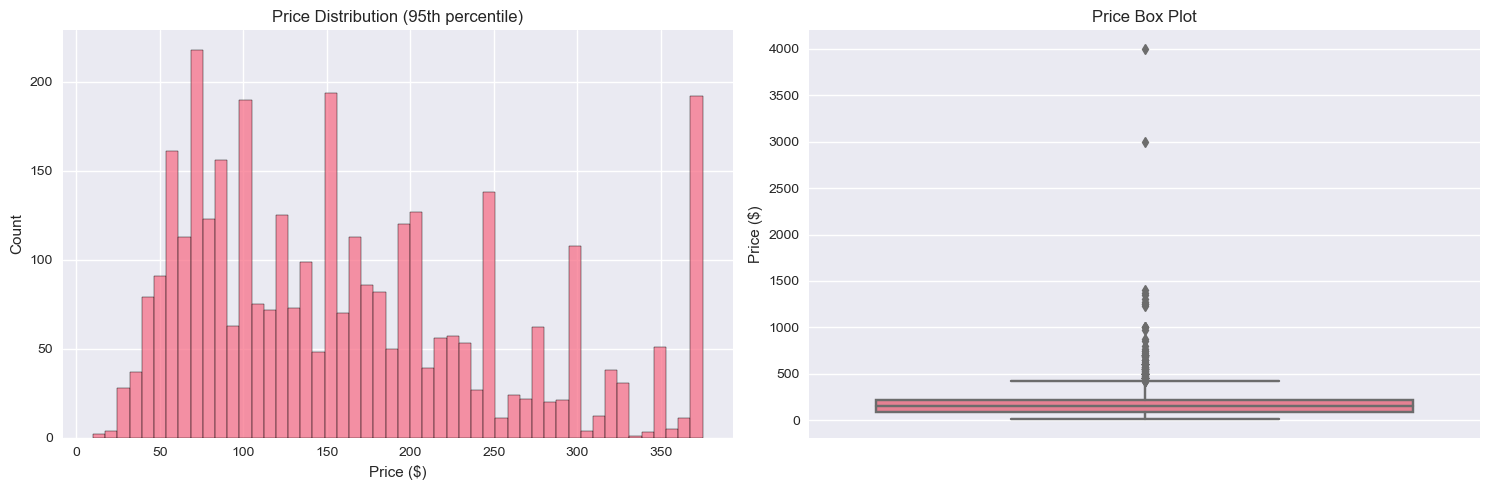

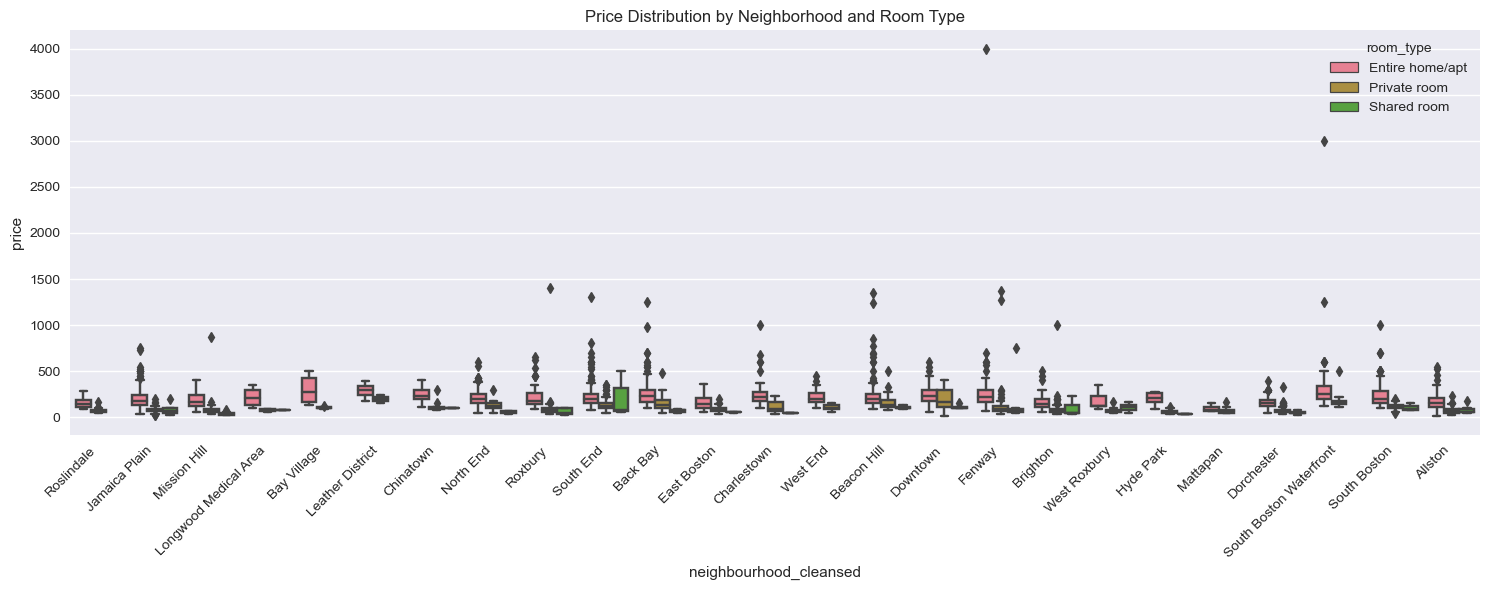

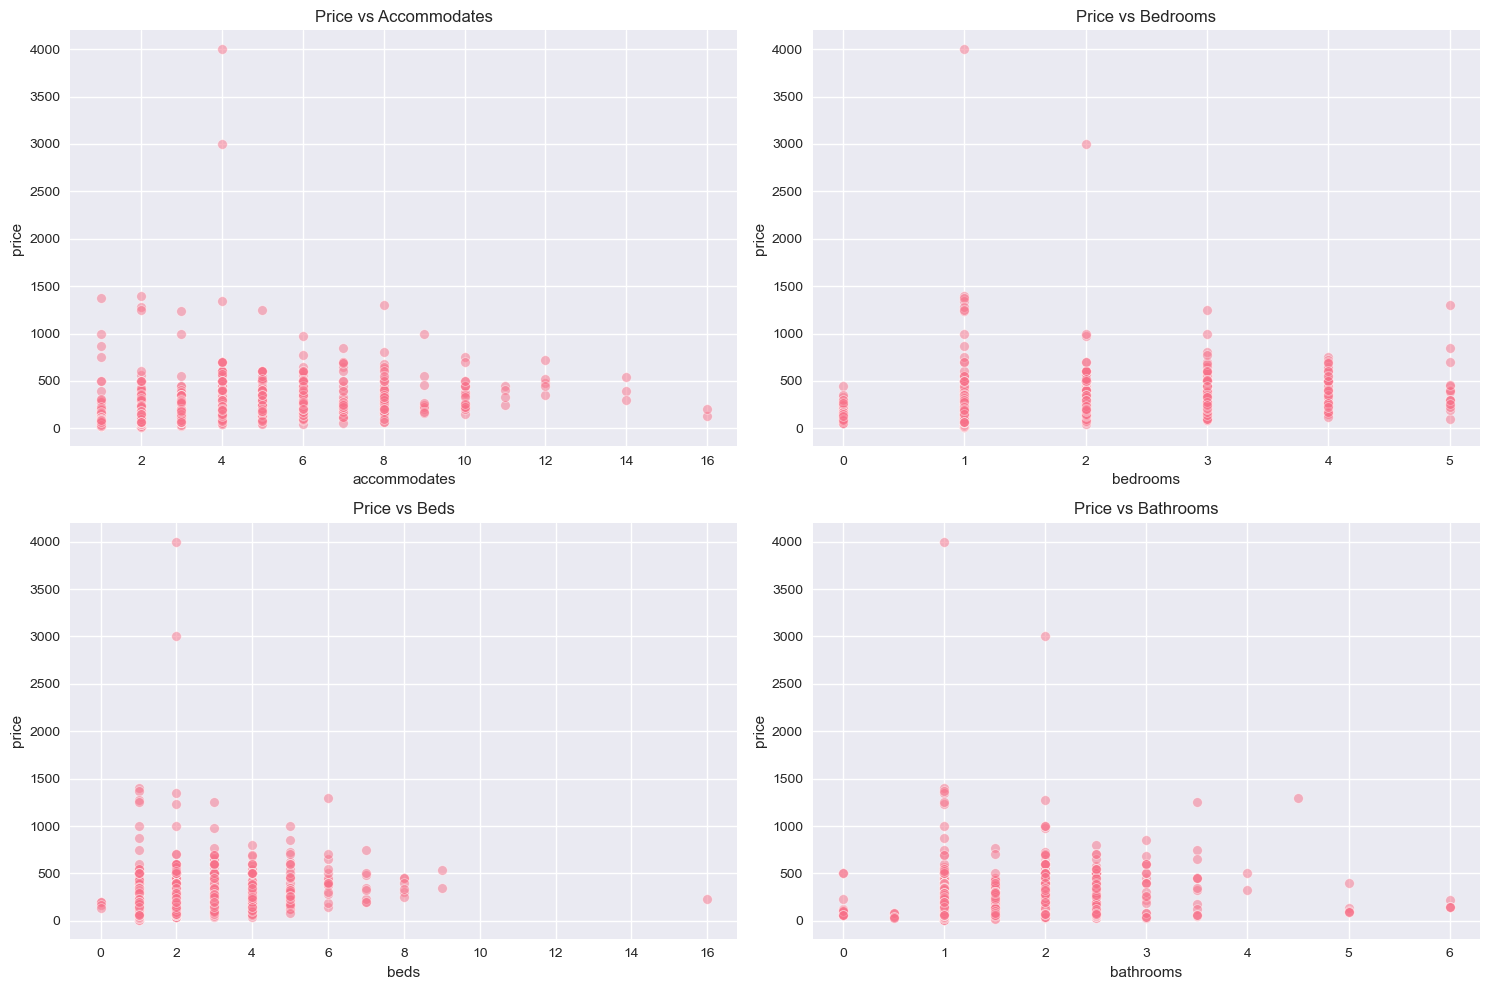

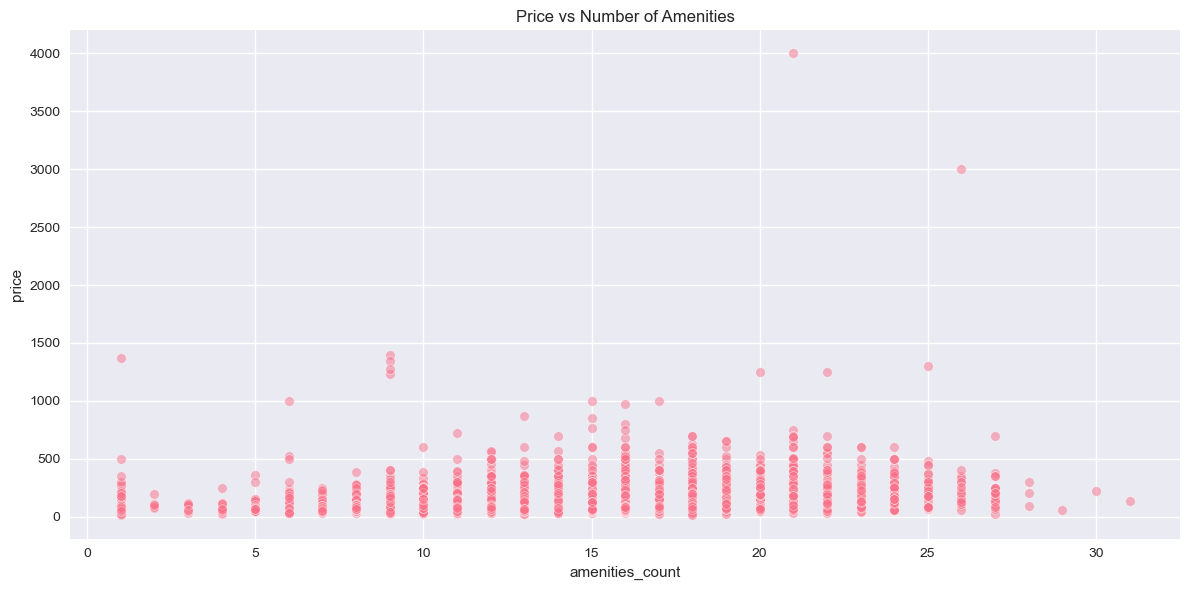

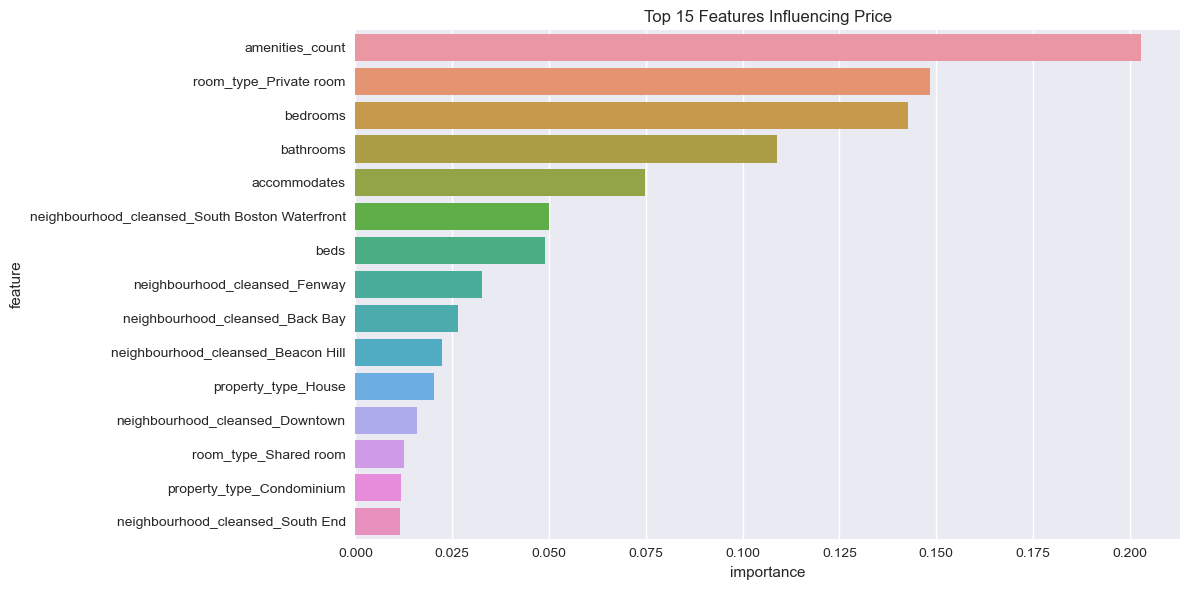


Key Findings:

Top 5 Satisfaction Drivers:
        feature  importance
4         price    0.608551
0  accommodates    0.157913
1     bathrooms    0.101129
3          beds    0.088798
2      bedrooms    0.043608

Top 5 Price Influencing Factors:
                   feature  importance
4          amenities_count    0.202821
41  room_type_Private room    0.148342
2                 bedrooms    0.142624
1                bathrooms    0.109008
0             accommodates    0.074824


In [118]:
def main():
    """
    Execute the complete analysis pipeline.
    
    Coordinates the entire analysis workflow from data loading to final results.
    
    Steps:
        1. Data loading and cleaning
        2. Seasonal trend analysis
        3. Satisfaction driver analysis
        4. Market pricing analysis
    
    Returns:
        dict: Results from all analyses:
            - seasonal_stats: Seasonal patterns
            - satisfaction_importance: Satisfaction drivers
            - price_importance: Price influencing factors
    
    Output:
        - Prints progress updates
        - Displays visualizations
        - Shows key findings"""
        
    print("Loading and preparing data...")
    load_data()
    
    print("\nAnalyzing seasonal trends...")
    seasonal_df = prepare_seasonal_analysis(calendar_df, listings_df)
    seasonal_stats = analyze_seasonal_trends(seasonal_df)
    
    print("\nAnalyzing satisfaction drivers...")
    satisfaction_df = prepare_satisfaction_analysis(listings_df, reviews_df)
    satisfaction_importance = analyze_satisfaction_drivers(satisfaction_df)
    
    print("\nAnalyzing market pricing factors...")
    pricing_df = prepare_pricing_analysis(listings_df)
    price_importance = analyze_market_pricing(pricing_df)
    
    print("\nKey Findings:")
    print("\nTop 5 Satisfaction Drivers:")
    print(satisfaction_importance.head())
    
    print("\nTop 5 Price Influencing Factors:")
    print(price_importance.head())
    
    return {
        "seasonal_stats": seasonal_stats,
        "satisfaction_importance": satisfaction_importance,
        "price_importance": price_importance
    }

if __name__ == "__main__":
    results = main()

# 5. Result Evaluation

1. **Seasonal Trends Analysis**:
- Clear seasonal pricing patterns with peak prices in September-October across most neighborhoods
- Significant price variations between neighborhoods, with Back Bay and South Boston Waterfront showing consistently higher prices
- Notable drop in availability rates in September (likely due to student housing demand in Boston)
- Winter months (December-February) show relatively stable pricing and higher availability
- Property type availability varies significantly by season, with Camper/RV showing highest availability (near 100%) and dorms showing seasonal patterns aligned with academic year

2. **Guest Satisfaction/Property Performance Analysis**:
- Strong correlation (0.74) between number of bedrooms and accommodates
- Price has moderate positive correlation (0.59) with accommodates
- Reviews per month and review scores show very weak correlation with property features
- All rating components (accuracy, cleanliness, check-in, communication, location, value) show consistently high scores (around 9/10)
- Price is the most important feature influencing review scores (0.68 importance), followed by accommodates (0.16)
- Property types show similar satisfaction levels, with slight variations

3. **Property Market Pricing Analysis**:
- Price shows strong relationship with property size metrics (bedrooms, bathrooms, accommodates)
- Number of amenities is the strongest price influencer (0.20 importance)
- Room type (Private room) is the second most important factor (0.15)
- Location matters significantly: South Boston Waterfront, Fenway, and Back Bay command premium prices
- Most properties are priced between 11-763 dollars, with some outliers up to 7000+ dollars
- Strong linear relationship between number of beds/bathrooms and price

Key insights:
1. Timing matters: September-October is the peak pricing period
2. Location premium: Certain neighborhoods consistently command higher prices
3. Amenities drive value: More amenities correlate with higher prices
4. Size matters: Number of accommodates/bedrooms/bathrooms strongly influences price
5. Satisfaction is consistent: Most properties maintain high review scores regardless of price point
